### Binary Classification Using VQClassifier with JAX Backend in FastQML

This demonstration showcases the FastQML library's capabilities in implementing and training Quantum Machine Learning (QML) models efficiently. FastQML, integrated with PennyLane, allows customizable components for each part of the model implementation. Here, we focus on employing the Variational Quantum Classifier (VQClassifier) for binary classification. The VQClassifier utilizes quantum circuits for data processing and is enhanced by JAX for accelerated CPU computations. The demo includes steps for setting up the quantum circuit, dataset preparation, and classifier execution, emphasizing FastQML's performance enhancements.

In [1]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import fast_qml
import pennylane as qml
from fast_qml.quantum_circuits.feature_maps import AmplitudeEmbedding
from fast_qml.quantum_circuits.variational_forms import TwoLocal, Ansatz
from fast_qml.machine_learning.estimators.vqa import VQClassifier
from fast_qml.machine_learning.callbacks import EarlyStopping

To compare the execution time of the training process across different backends (default PennyLane interface and JAX interface with Just-in-time compilation), we utilize a custom decorator. This decorator measures and displays the execution time of the function it wraps, providing insights into the performance improvements offered by JAX.

In [2]:
def execution_time(func):
    """
    A decorator that prints the execution time of the function it decorates.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs) 
        end_time = time.time()
        print(f"Executing {func.__name__} took {end_time - start_time:.5f} seconds.")
        return result
    return wrapper

The breast cancer dataset from sklearn serves as our binary classification task. This dataset, derived from digitized images of fine needle aspirates of breast masses, contains 30 features representing cell nuclei characteristics. The classification task is to categorize these instances as benign or malignant.

We begin by normalizing the data and dividing it into training, validation, and testing sets. This step is crucial for a comprehensive evaluation of the VQClassifier's performance.

In [3]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape, X_val.shape)

(455, 30) (57, 30) (57, 30)


In this step, we will construct the fundamental components of our quantum classifier using FastQML: the feature map and the ansatz. The feature map's role is to encode classical data into a quantum state. For this purpose, we will utilize the AmplitudeEmbedding method from FastQML, which efficiently encodes data into quantum states. Given that a single sample from our dataset contains 30 features, and AmplitudeEmbedding can encode 2^qubits_number of features, we will use 5 qubits. This configuration allows us to encode up to 32 features, with the last two being padded with 0.0 to fit our data structure.

Next, we will set up the ansatz for our quantum classifier. The ansatz, composed of a sequence of quantum gates, is responsible for processing the quantum data. In this demonstration, we will employ the TwoLocal form available in FastQML. The TwoLocal form is a versatile and commonly used ansatz, and we will use it with its default parameters. This choice provides a balance between simplicity and the ability to demonstrate the essential features of quantum data processing in FastQML.

By following these steps, we effectively establish the quantum environment necessary for our classifier, showcasing the ease and flexibility of feature mapping and ansatz configuration in FastQML.

In [4]:
# With 5 qubits we have 2^5=32 features at maximum to be encoded
n_qubits = 5

# Create AmplitudeEmbedding feature map with 0.0 padding
feature_map = AmplitudeEmbedding(
    n_qubits=n_qubits,
    pad_with=0.0
)

# TwoLocal ansatz with default parameters
ansatz = TwoLocal(
    n_qubits=n_qubits,
    controlled_gate='CNOT',
    entanglement='linear',
    skip_last_rotations=False,
    reps=2
)

In [5]:
# Create VQClassifier model with defined ansatz and feature map
model = VQClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    classes_num=2
)

To better understand the structure of our quantum circuit, we can visualize it with build-in _draw_circuit()_ method. It can be usefully in debugging and optimizing the quantum circuit design.

In [6]:
model.draw_circuit()

0: ─╭|Ψ⟩──RY(0.02)─╭●───────────||──RY(0.07)─╭●───────────||──RY(0.10)─┤  
1: ─├|Ψ⟩──RY(0.05)─╰X─╭●────────||──RY(0.01)─╰X─╭●────────||──RY(0.09)─┤  
2: ─├|Ψ⟩──RY(0.05)────╰X─╭●─────||──RY(0.00)────╰X─╭●─────||──RY(0.04)─┤  
3: ─├|Ψ⟩──RY(0.03)───────╰X─╭●──||──RY(0.06)───────╰X─╭●──||──RY(0.01)─┤  
4: ─╰|Ψ⟩──RY(0.01)──────────╰X──||──RY(0.03)──────────╰X──||──RY(0.02)─┤  


At this stage, we are ready to train our quantum classifier using FastQML. The training process is designed to optimize the model's parameters based on the training data, while also incorporating validation data to ensure robustness and generalizability. To proceed with training, we will set the number of epochs to 150. An epoch is a complete pass through the entire training dataset, and this number determines the duration of the training process. The choice of 250 epochs allows for a thorough optimization of the model's parameters.

Additionally, we will set the learning rate to 0.3. The learning rate is a crucial hyperparameter in machine learning that influences the rate at which the model learns. A learning rate of 0.3 is selected to balance the speed of convergence and the stability of the training process.

In [7]:
@execution_time
def fit_model():
    model.fit(
        x_train=X_train,
        y_train=y_train,
        x_val=X_val,
        y_val=y_val,
        num_epochs=150,
        learning_rate=0.3
    )
    
fit_model()

Epoch 1/150 - train_loss: 0.69144, val_loss: 0.64049
Epoch 2/150 - train_loss: 0.66405, val_loss: 0.71313
Epoch 3/150 - train_loss: 0.69759, val_loss: 0.77663
Epoch 4/150 - train_loss: 0.72126, val_loss: 0.80738
Epoch 5/150 - train_loss: 0.72721, val_loss: 0.81478
Epoch 6/150 - train_loss: 0.70773, val_loss: 0.78315
Epoch 7/150 - train_loss: 0.67986, val_loss: 0.71883
Epoch 8/150 - train_loss: 0.71892, val_loss: 0.70163
Epoch 9/150 - train_loss: 0.71673, val_loss: 0.70435
Epoch 10/150 - train_loss: 0.68414, val_loss: 0.70623
Epoch 11/150 - train_loss: 0.68307, val_loss: 0.74176
Epoch 12/150 - train_loss: 0.69703, val_loss: 0.77858
Epoch 13/150 - train_loss: 0.69987, val_loss: 0.78708
Epoch 14/150 - train_loss: 0.68795, val_loss: 0.76586
Epoch 15/150 - train_loss: 0.67176, val_loss: 0.72750
Epoch 16/150 - train_loss: 0.66794, val_loss: 0.69404
Epoch 17/150 - train_loss: 0.67700, val_loss: 0.68008
Epoch 18/150 - train_loss: 0.67215, val_loss: 0.67683
Epoch 19/150 - train_loss: 0.65710, v

We trained the model in **~4.51 seconds**.

With the model now trained, our next step is to evaluate its performance on the test data. In order to present the model's performance Scikit-learn _classification_report_ and _ConfusionMatrixDisplay_ methods will be used.

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.84      0.88      0.86        41

    accuracy                           0.79        57
   macro avg       0.74      0.72      0.73        57
weighted avg       0.78      0.79      0.78        57


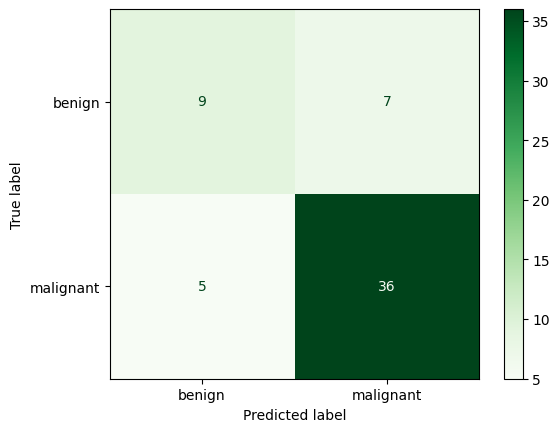

In [8]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap='Greens')
plt.show()

Having achieved approximately 80% accuracy with our current model setup, our next objective is to enhance the model's performance while also aiming for a more efficient training time. To accomplish this, we will explore the customization capabilities of FastQML by implementing a custom variational function.

Furthermore, we will utilize the JAX backend for training. The JAX backend in FastQML is known for its efficiency in computation, particularly beneficial for quantum machine learning tasks. By leveraging Just-in-Time (JIT) compilation and other optimization features of JAX, we anticipate a reduction in training time without compromising the model's performance.

In [9]:
# Set backend to JAX for CPU computations acceleration
fast_qml.update(device='cpu.jax')

In [10]:
n_qubits = 5

# Define custom variational function
def naive_var_func(params):
    # First block of rotations
    first_block_rotations = [qml.RX, qml.RY, qml.RX, qml.RY, qml.RX]
    for i, rotation in enumerate(first_block_rotations):
        rotation(params[i], wires=[i])
        
    # Second block of rotations
    rot_number = 0
    for i in range(0, n_qubits, 2):
        qml.RY(params[n_qubits + rot_number], wires=[i])
        rot_number += 1
    
# We wil use the same features map
feature_map = AmplitudeEmbedding(
    n_qubits=n_qubits,
    pad_with=0.0
)

# We can define ansatz with our user-defined variational form function
ansatz = Ansatz(
    n_qubits=n_qubits,
    variational_func=naive_var_func,
    parameters_num=8,
    entanglement='circular',
    reps=2
)

In [11]:
# Create VQClassifier model with defined ansatz and feature map
model = VQClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    classes_num=2
)

In [12]:
model.draw_circuit()

0: ─╭|Ψ⟩──RX(0.09)──RY(0.05)─╭●──────────╭X──||──RX(0.02)──RY(0.03)─╭●──────────╭X──||──RX(0.07)
1: ─├|Ψ⟩──RY(0.00)───────────╰X─╭●───────│───||──RY(0.06)───────────╰X─╭●───────│───||──RY(0.02)
2: ─├|Ψ⟩──RX(0.01)──RY(0.06)────╰X─╭●────│───||──RX(0.06)──RY(0.00)────╰X─╭●────│───||──RX(0.03)
3: ─├|Ψ⟩──RY(0.02)─────────────────╰X─╭●─│───||──RY(0.07)─────────────────╰X─╭●─│───||──RY(0.05)
4: ─╰|Ψ⟩──RX(0.10)──RY(0.10)──────────╰X─╰●──||──RX(0.08)──RY(0.05)──────────╰X─╰●──||──RX(0.05)

───RY(0.01)─┤  
────────────┤  
───RY(0.08)─┤  
────────────┤  
───RY(0.08)─┤  


In [14]:
@execution_time
def fit_model():
    model.fit(
        x_train=X_train,
        y_train=y_train,
        x_val=X_val,
        y_val=y_val,
        learning_rate=0.3,
        num_epochs=150
    )
    
fit_model()

Epoch 1/150 - train_loss: 0.43728, val_loss: 0.54271
Epoch 2/150 - train_loss: 0.62788, val_loss: 0.61781
Epoch 3/150 - train_loss: 0.53856, val_loss: 0.50884
Epoch 4/150 - train_loss: 0.48991, val_loss: 0.49824
Epoch 5/150 - train_loss: 0.51431, val_loss: 0.52020
Epoch 6/150 - train_loss: 0.50182, val_loss: 0.54541
Epoch 7/150 - train_loss: 0.50821, val_loss: 0.51273
Epoch 8/150 - train_loss: 0.48849, val_loss: 0.45940
Epoch 9/150 - train_loss: 0.46390, val_loss: 0.44079
Epoch 10/150 - train_loss: 0.46369, val_loss: 0.45262
Epoch 11/150 - train_loss: 0.46572, val_loss: 0.47794
Epoch 12/150 - train_loss: 0.46655, val_loss: 0.50271
Epoch 13/150 - train_loss: 0.47062, val_loss: 0.50419
Epoch 14/150 - train_loss: 0.46578, val_loss: 0.48143
Epoch 15/150 - train_loss: 0.45267, val_loss: 0.45582
Epoch 16/150 - train_loss: 0.44597, val_loss: 0.44300
Epoch 17/150 - train_loss: 0.44935, val_loss: 0.44321
Epoch 18/150 - train_loss: 0.45260, val_loss: 0.45281
Epoch 19/150 - train_loss: 0.45248, v

Remarkably, the training time with the customized variational function and JAX backend in FastQML has been reduced to approximately 0.78 seconds. This is a significant improvement, showcasing more than 5.5 times faster execution compared to the previous setup.

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.93      0.95      0.94        41

    accuracy                           0.91        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.91      0.91      0.91        57


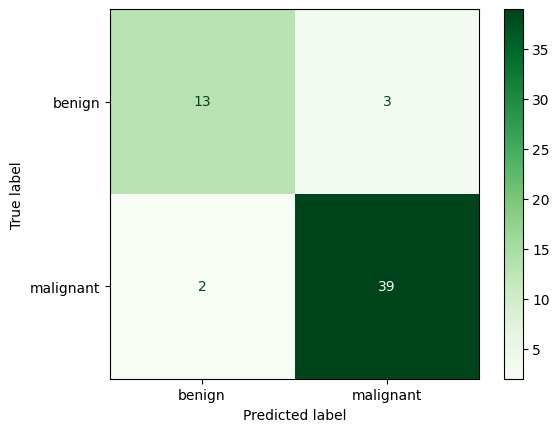

In [15]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap='Greens')
plt.show()

With the implementation of custom variational functions and the JAX backend in FastQML, we have successfully improved the model's accuracy to approximately 91%

Observing the variational loss, we noted that it plateaued after a certain number of epochs. This indicates an opportunity to optimize the training process further. To address this, we will implement the early stopping mechanism available in FastQML. Early stopping is a powerful technique that halts the training process once the model ceases to show improvement over a defined number of epochs. This approach not only saves computational resources but also prevents potential overfitting.

In [18]:
early_stopping = EarlyStopping()

@execution_time
def fit_model():
    model.fit(
        x_train=X_train,
        y_train=y_train,
        x_val=X_val,
        y_val=y_val,
        learning_rate=0.3,
        num_epochs=500,
        early_stopping=early_stopping
    )
    
fit_model()

Epoch 1/500 - train_loss: 0.43730, val_loss: 0.58552
Epoch 2/500 - train_loss: 0.80783, val_loss: 0.48262
Epoch 3/500 - train_loss: 0.47486, val_loss: 0.48461
Epoch 4/500 - train_loss: 0.47149, val_loss: 0.53393
Epoch 5/500 - train_loss: 0.53347, val_loss: 0.57759
Epoch 6/500 - train_loss: 0.53496, val_loss: 0.62637
Epoch 7/500 - train_loss: 0.54951, val_loss: 0.62273
Epoch 8/500 - train_loss: 0.54643, val_loss: 0.58412
Epoch 9/500 - train_loss: 0.53182, val_loss: 0.55488
Epoch 10/500 - train_loss: 0.52625, val_loss: 0.53789
Epoch 11/500 - train_loss: 0.51389, val_loss: 0.53007
Epoch 12/500 - train_loss: 0.49674, val_loss: 0.52230
Epoch 13/500 - train_loss: 0.48503, val_loss: 0.49628
Epoch 14/500 - train_loss: 0.47130, val_loss: 0.46047
Epoch 15/500 - train_loss: 0.45955, val_loss: 0.43705
Epoch 16/500 - train_loss: 0.46044, val_loss: 0.42969
Epoch 17/500 - train_loss: 0.46672, val_loss: 0.42922
Epoch 18/500 - train_loss: 0.46502, val_loss: 0.43653
Epoch 19/500 - train_loss: 0.45899, v

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.93      0.95      0.94        41

    accuracy                           0.91        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.91      0.91      0.91        57


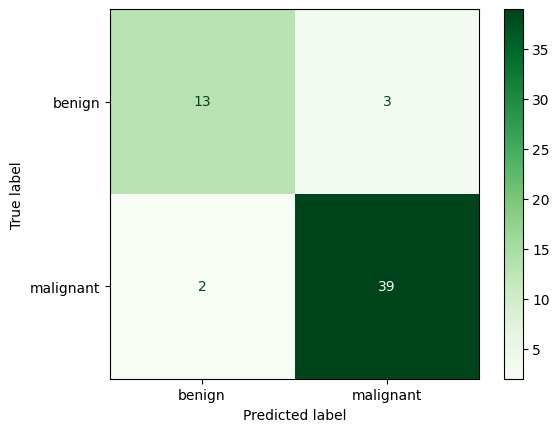

In [19]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap='Greens')
plt.show()

Cool, we have successfully achieved the same level of model accuracy, but in fewer epochs!